In [1]:
import pandas as pd

from jinja2 import Environment, FileSystemLoader
import sqlite3

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report

from yellowbrick.classifier import ConfusionMatrix, ROCAUC, ClassPredictionError
from yellowbrick.style import set_palette

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

import pickle

pd.set_option('display.max_columns', 75)

In [2]:
# Seed para valores aleatorios
SEED = 124

## 1.0 Carrega a tabela

In [3]:
# inicia o jinja
templateLoader = FileSystemLoader("../../models/templates/")
environment = Environment(loader=templateLoader)

In [4]:
# cria um banco de dados no caminho especificado
conn = sqlite3.connect('../../data/DB/credit_risk')
cursor = conn.cursor()

In [5]:
# Arquivos jinja
FILE_MERGE_COSTUMER_PAYMENT = environment.get_template("customer_payment_merge.sql.j2")   

In [6]:
#carrega template do jinja
query_merge_customer_payment = environment.get_template(FILE_MERGE_COSTUMER_PAYMENT).render(id="id")
# exibe a tabela com merge de customer e payment
merge_customer_payment = pd.read_sql_query(query_merge_customer_payment, conn)
merge_customer_payment = merge_customer_payment.loc[:,~merge_customer_payment.columns.duplicated()].copy()
merge_customer_payment.head(3)

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date,label,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,None,0,5,1241.0,3,62000.0,2,15,9,95,4,60023,1.000000
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,None,1,7,NaN,2,126000.0,2,11,9,115,4,450028,224.267697
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016,0,7,1376.0,1,150000.0,2,11,-1,110,4,60000,219.248717


In [7]:
# carrega base pagamento e customer com merge
print(f"tamanho da tabrla de merge: {merge_customer_payment.shape}")
print(merge_customer_payment.query("prod_code.isna()", engine="python").shape[0])

tamanho da tabrla de merge: (8250, 24)
0


## 2.0 Analise exploratoria da tabela

De acordo com o kaggle: 
* label = 0 "low credit risk"  
* label = 1 "high credit risk"  
* os fea_* podem náo contribuir ja que nao sao variaveis explicativas e sim de cadastro

In [8]:
# colunas vazias
nulls = pd.DataFrame(merge_customer_payment.isna().sum()).rename(columns={0:'qtd'}).query("qtd > 0")
nulls

,qtd
prod_limit,6118
update_date,26
highest_balance,409
report_date,1114
fea_2,1028


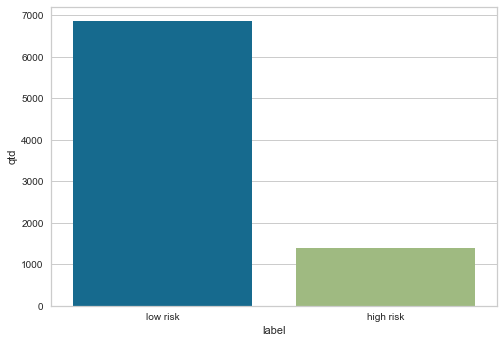

os dados estao um pouco desbalanceados
percentul: 0.20209820778085386


In [9]:
# visualizacao da distribuicao da variavel resposta
aux = (pd.DataFrame(merge_customer_payment[['label']]
              .value_counts()
              .reset_index()
              .rename(columns={0:'qtd'})))
aux['label'] = aux['label'].map({0 : "low risk", 
                                1 : "high risk"})
sns.barplot(x='label',y='qtd', data=aux)
plt.show()
print("os dados estao um pouco desbalanceados")
print(f"percentul: {aux['qtd'][1] / aux['qtd'][0]}")

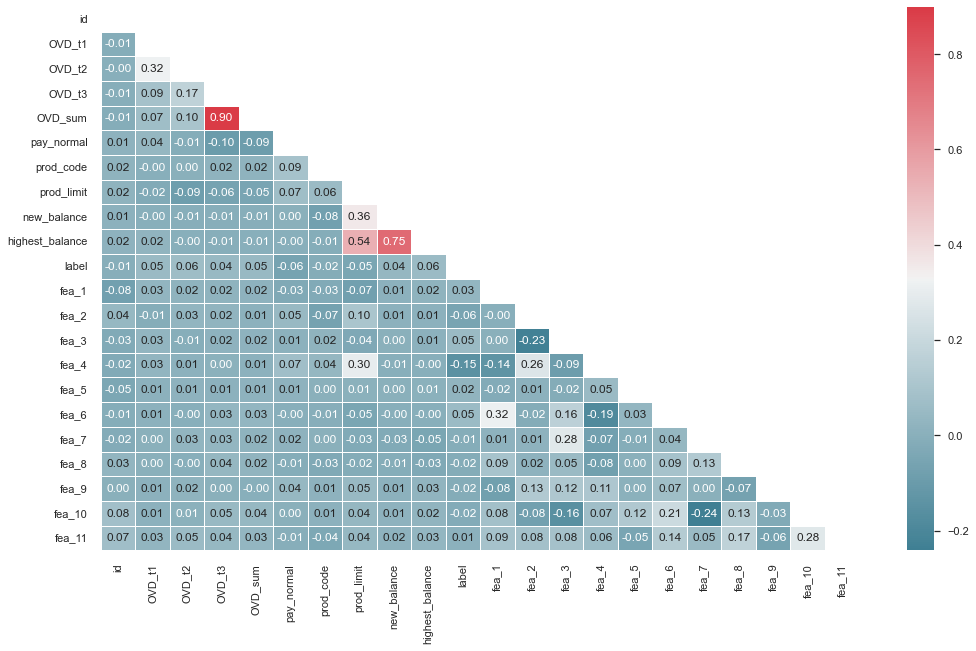

In [10]:
# correlacao das variaveis
sns.set(style="white")
f, ax = plt.subplots(figsize=(17,10))

#correlacao
corr = merge_customer_payment.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, 
            mask=mask,
            annot=True, 
            linewidths=0.5,
            #center=0,
            #square=True,
            fmt='.2f',
            ax=ax
           )
plt.show()

In [11]:
# colunas mais correlacionados
high_corr = (pd.DataFrame(corr[corr >= 0.75].sum())
             .reset_index()
             .rename(columns={0:"corr"})
             .query("corr > 1")
            )

print("retirar o OVD_t3 e deixar o OVD_sum, pois OVD_sum esta mais relacionado com a var resposta")
print("retirar o highest_balance e deixar o new_balance, pois highest_balance \n\
por mais que seja mais corr com a label, tem mais vazios")
high_corr

retirar o OVD_t3 e deixar o OVD_sum, pois OVD_sum esta mais relacionado com a var resposta
retirar o highest_balance e deixar o new_balance, pois highest_balance 
por mais que seja mais corr com a label, tem mais vazios


,index,corr
3,OVD_t3,1.899413
4,OVD_sum,1.899413
8,new_balance,1.751602
9,highest_balance,1.751602


## 3.0 lidando com os vazios e correlacoes

In [12]:
nulls

,qtd
prod_limit,6118
update_date,26
highest_balance,409
report_date,1114
fea_2,1028


In [13]:
merge_customer_payment.columns

Index(['id', 'OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal',
       'prod_code', 'prod_limit', 'update_date', 'new_balance',
       'highest_balance', 'report_date', 'label', 'fea_1', 'fea_2', 'fea_3',
       'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 'fea_10',
       'fea_11'],
      dtype='object')

In [14]:
#sera removido as colunas de datas, prod_limit por ter muitos vazios, e as variaveis altamente correlacionadas
# prod_cod sera removido por nao ser significativo
columns = ['id', 'OVD_t1', 'OVD_t2', 'OVD_sum', 'pay_normal',
           'new_balance', 'label', 'fea_1', 'fea_2', 'fea_3',
           'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9',
           'fea_10', 'fea_11']
new_customer_payment = merge_customer_payment[columns]
# substituindo os nulls do fea_2 pela media
new_customer_payment['fea_2'].fillna(new_customer_payment['fea_2'].mean(), inplace=True)
new_customer_payment.head(3)

/Users/greg/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,id,OVD_t1,OVD_t2,OVD_sum,pay_normal,new_balance,label,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,58987402,0,0,0,1,0.0,0,5,1241.000000,3,62000.0,2,15,9,95,4,60023,1.000000
1,58995151,0,0,0,1,588720.0,1,7,1286.156813,2,126000.0,2,11,9,115,4,450028,224.267697
2,58997200,0,0,0,2,840000.0,0,7,1376.000000,1,150000.0,2,11,-1,110,4,60000,219.248717


In [15]:
# checando se ainda existe nulls
new_customer_payment.isnull().sum()

id             0
OVD_t1         0
OVD_t2         0
OVD_sum        0
pay_normal     0
new_balance    0
label          0
fea_1          0
fea_2          0
fea_3          0
fea_4          0
fea_5          0
fea_6          0
fea_7          0
fea_8          0
fea_9          0
fea_10         0
fea_11         0
dtype: int64

## 3.1 Salvando base de modelagem

In [16]:
# cria a tabela de modelagem
cursor.execute(f'CREATE TABLE IF NOT EXISTS modeling_data {tuple(new_customer_payment.columns)}')
conn.commit()
new_customer_payment.to_sql('modeling_data', conn, if_exists='replace', index = False)

## 4.0 detectando outliers

In [17]:
# clf = LocalOutlierFactor()

# y_pred = clf.fit_predict(new_customer_payment.dropna())

## 5.0 Treino, Teste e Balanceamento

In [18]:
# separando X e y
X = new_customer_payment.drop(columns=['label','id'])
y = new_customer_payment['label']

# balanceamento
os = RandomOverSampler(sampling_strategy=0.75)
X_res, y_res = os.fit_resample(X, y)
print(f"novo X tem:{X_res.shape}, novo y tem:{y_res.shape}")
print(f"Base original tem:{Counter(y)}")
print(f"Base redimensionada tem:{Counter(y_res)}")

# treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_res,
                                                    y_res,
                                                    train_size=0.75,
                                                    test_size = 0.25,
                                                    random_state=SEED)

novo X tem:(12010, 16), novo y tem:(12010,)
Base original tem:Counter({0: 6863, 1: 1387})
Base redimensionada tem:Counter({0: 6863, 1: 5147})


## 6.0 Modelo

### 6.1 Random Forest

In [19]:
#random forest
r_forest = RandomForestClassifier(random_state=SEED)
r_forest.fit(X_train, y_train)

# score
predicted = r_forest.predict(X_test)
score_test = r_forest.score(X_test, y_test)
score_train = r_forest.score(X_train, y_train)
print(f"score de teste foi:{score_test.round(5)}, score de treino foi:{score_train.round(5)}")

score de teste foi:0.996, score de treino foi:1.0


/Users/greg/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


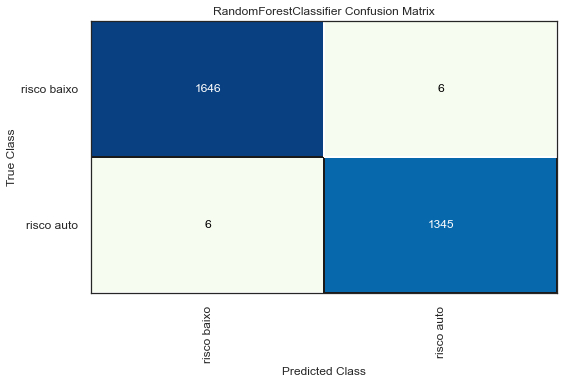

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [20]:
# matrix de confusao do resultado
classes = ['risco baixo', 'risco auto']
r_forest_cm = ConfusionMatrix(r_forest, classes=classes, cmap='GnBu')

#treinando a matrix
r_forest_cm.fit(X_train, y_train)
r_forest_cm.score(X_test, y_test)
r_forest_cm.show()

In [21]:
# resultados do modelo
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       1.00      1.00      1.00      1351

    accuracy                           1.00      3003
   macro avg       1.00      1.00      1.00      3003
weighted avg       1.00      1.00      1.00      3003



/Users/greg/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


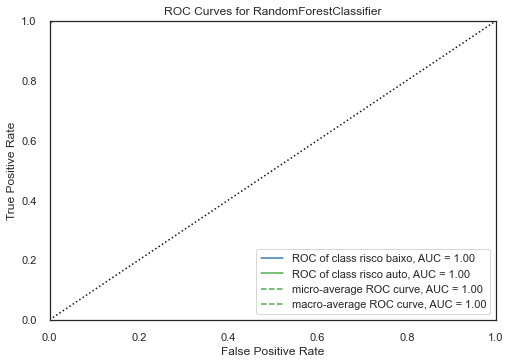

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [22]:
# ROC AUC para ferificar overfitting
visualizer = ROCAUC(r_forest, classes=classes)
set_palette('bold')
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

/Users/greg/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


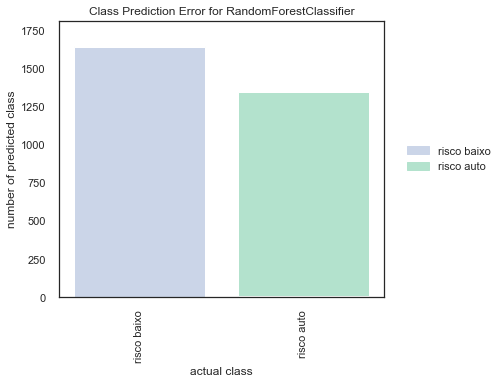

<AxesSubplot:title={'center':'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [23]:
# visualizar os erros
visualizer = ClassPredictionError(r_forest, classes=classes)
set_palette('pastel')
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

### 6.2 GradientBoosting

In [24]:
# gradientboosting
clf_gb = GradientBoostingClassifier(random_state=SEED)
clf_gb.fit(X_train, y_train)

# score
predicted_gb = clf_gb.predict(X_test)
score_test = clf_gb.score(X_test, y_test)
score_train = clf_gb.score(X_train, y_train)
print(f"score de teste foi:{score_test.round(5)}, score de treino foi:{score_train.round(5)}")

score de teste foi:0.8375, score de treino foi:0.85223


/Users/greg/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


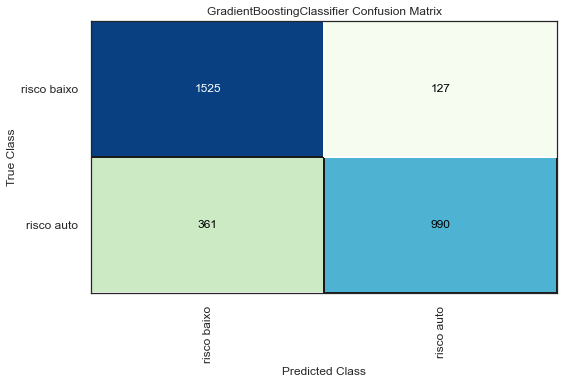

<AxesSubplot:title={'center':'GradientBoostingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [25]:
# matrix de confusao do resultado
classes = ['risco baixo', 'risco auto']
clf_gb_cm = ConfusionMatrix(clf_gb, classes=classes, cmap='GnBu')

#treinando a matrix
clf_gb_cm.fit(X_train, y_train)
clf_gb_cm.score(X_test, y_test)
clf_gb_cm.show()

In [26]:
# resultados do modelo
print(classification_report(y_test, predicted_gb))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1652
           1       0.89      0.73      0.80      1351

    accuracy                           0.84      3003
   macro avg       0.85      0.83      0.83      3003
weighted avg       0.84      0.84      0.84      3003



/Users/greg/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


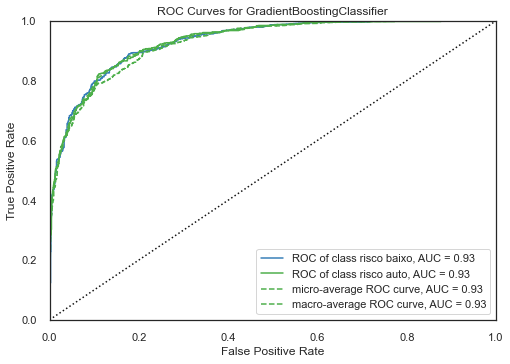

<AxesSubplot:title={'center':'ROC Curves for GradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [27]:
# ROC AUC para ferificar overfitting
visualizer = ROCAUC(clf_gb, classes=classes)
set_palette('bold')
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

/Users/greg/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


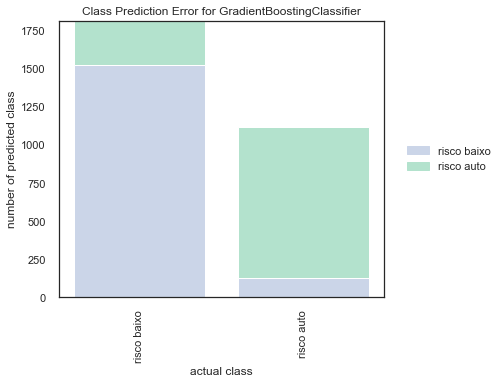

<AxesSubplot:title={'center':'Class Prediction Error for GradientBoostingClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [28]:
# visualizar os erros
visualizer = ClassPredictionError(clf_gb, classes=classes)
set_palette('pastel')
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## 7.0 Salvando o modelo

In [29]:
# salvando o modelo random forest
filename = '../../models/trained_models/r_forest.sav'
pickle.dump(r_forest, open(filename, 'wb'))

In [30]:
# fechar conexao
conn.close()